In [11]:
# Notes - 98% test accuracy with supervised model. This pipeline
# works for each individual file, just need to write a for loop to iterate through all the files.
# Currently coding up unsupervised clustering approach.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

path = 'ace_sis_low_2595-3.txt'
data = []
hist = []
with open(path, 'r') as file:
    for line in file:
        parts = line.split()
        if len(parts) == 3:
            if hist:
                data.append(hist)
            hist = [int(x) for x in parts]
        else:
            hist.extend(map(int, parts))
if hist:
    data.append(hist)

cols = ['year', 'day', 'hour'] + [f'bin_{i+1}' for i in range(60)]
df = pd.DataFrame(data, columns=cols)
# Using Values from professor
he3_start = int((2.7 - 2) / 0.05)
he3_end = int((3.3 - 2) / 0.05)
he4_start = int((3.7 - 2) / 0.05)
he4_end = int((4.3 - 2) / 0.05)

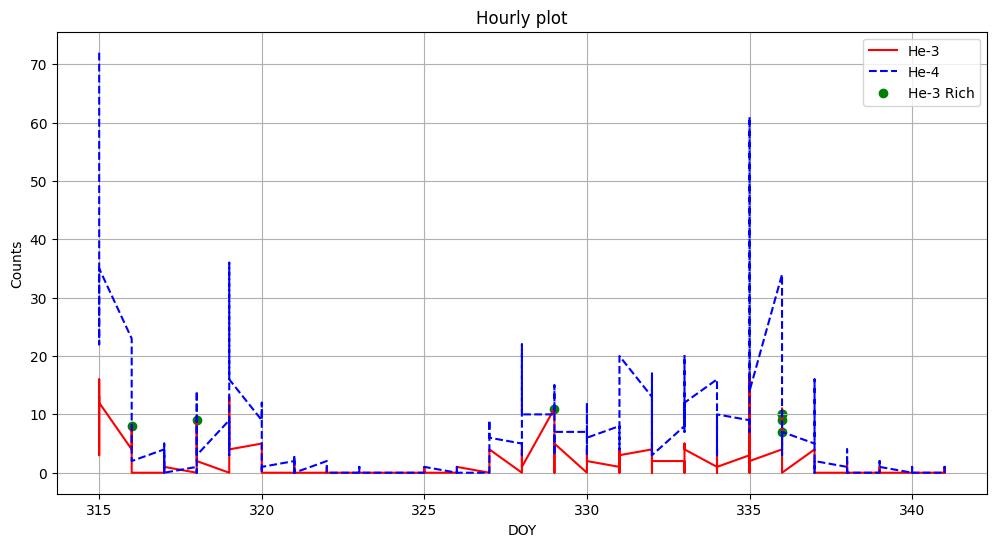

In [13]:
filtered = df[(df['day'] >= 315) & (df['day'] <= 341)]
filtered['He-3'] = filtered.iloc[:, 3+he3_start:3+he3_end+1].sum(axis=1)
filtered['He-4'] = filtered.iloc[:, 3+he4_start:3+he4_end+1].sum(axis=1)
filtered['He-3 Rich'] = (filtered['He-3'] >= 0.5 * filtered['He-4']) & ((filtered['He-3'] + filtered['He-4']) >= 20)
# Working with hourly plot instead of daily
plt.figure(figsize=(12, 6))
plt.plot(filtered['day'], filtered['He-3'], label='He-3', color='red')
plt.plot(filtered['day'], filtered['He-4'], label='He-4', color='blue', linestyle='--')
plt.scatter(filtered['day'][filtered['He-3 Rich']], filtered['He-3'][filtered['He-3 Rich']], color='green', marker='o', label='He-3 Rich')
plt.title('Hourly plot')
plt.xlabel('DOY')
plt.ylabel('Counts')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
filtered['He-3 Rich'] = ((filtered['He-3'] >= 0.5 * filtered['He-4']) & ((filtered['He-3'] + filtered['He-4']) >= 20)).astype(int)
X = filtered[['He-3', 'He-4']]
y = filtered['He-3 Rich']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [15]:
X = filtered[['He-3', 'He-4']]
y = filtered['He-3 Rich']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [16]:
model = Sequential([
    Dense(10, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(10, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train_scaled, y_train, epochs=50, validation_split=0.2)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.5744 - loss: 0.7771 - val_accuracy: 0.6154 - val_loss: 0.7608
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6667 - loss: 0.7197 - val_accuracy: 0.6813 - val_loss: 0.6968
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7294 - loss: 0.6699 - val_accuracy: 0.7363 - val_loss: 0.6438
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8332 - loss: 0.6084 - val_accuracy: 0.8352 - val_loss: 0.5957
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8528 - loss: 0.5679 - val_accuracy: 0.8901 - val_loss: 0.5480
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9371 - loss: 0.5164 - val_accuracy: 0.9121 - val_loss: 0.5041
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9256 - loss: 0.4949 - val_accuracy: 1.0000 - val_loss: 0.4625
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9813 - loss: 0.4517 - val_accuracy: 1.0000 - val_loss: 0.4243
E

In [17]:
test_loss, test_acc = model.evaluate(X_test_scaled, y_test)
print(f"Test Accuracy: {test_acc:.4f}")
y_pred = model.predict(X_test_scaled) > 0.5
print(classification_report(y_test, y_pred, target_names=['Non-Rich', 'He-3 Rich']))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
roc_auc = roc_auc_score(y_test, model.predict(X_test_scaled))
print(f"ROC-AUC Score: {roc_auc:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9944 - loss: 0.0316 
Test Accuracy: 0.9897
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
              precision    recall  f1-score   support

    Non-Rich       0.99      1.00      0.99       193
   He-3 Rich       0.00      0.00      0.00         2

    accuracy                           0.99       195
   macro avg       0.49      0.50      0.50       195
weighted avg       0.98      0.99      0.98       195

Confusion Matrix:
[[193   0]
 [  2   0]]
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
ROC-AUC Score: 0.9974


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
